<a href="https://colab.research.google.com/github/FatLads/Notebooks/blob/main/this_fucking_works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required libraries


* `flatland-rl` - http://flatland-rl-docs.s3-website.eu-central-1.amazonaws.com/
* `keras-rl` - https://github.com/keras-rl/keras-rl

In [1]:
!pip install flatland-rl

     |████████████████████████████████| 3.3MB 12.9MB/s 
  Using cached https://files.pythonhosted.org/packages/ec/7e/4609fd0386d41f0b94fe952708970fb87cc1fb66e088758b1f0ab336802e/tox-3.23.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/70/c7/e8cb4a537ee4fc497ac80a606a667fd1832f28ad3ddbfa25bf30473eae13/pytest-4.6.11-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/40/96/9024a1c07bbe5e16bdcbcbd021b608e37b32df4301ae2090aad27c24ffe6/pytest_runner-5.3.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0c/ee/55912b05af8994a190280e3281a18720f8d69da02dcb7ff44e1b96974345/crowdai_api-0.1.22.tar.gz
  Using cached https://files.pythonhosted.org/packages/60/9a/835ba329e31aa471a5597c733f7ca0136b3a0622ce01b9e66b40f5909da4/recordtype-1.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a8/7b/630049fc4af9e68a625738612edc264ce7cb586c5001a2d4d2209a4f61c1/msgpack-0.6.1-cp37-cp37m-manylinux1_x86_64.whl

In [86]:
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
from flatland.envs.rail_env import RailEnv, RailEnvActions


In [3]:
!pip install keras-rl2

     |████████████████████████████████| 61kB 5.9MB/s 


# Environment

Let's build a simple environment using [GlobalObservation](https://flatland.aicrowd.com/getting-started/env/observations.html#global-observation), the easiest one.

In [296]:
class OurEnv(RailEnv):
    def reset(self, *args, **kwargs):
        return_val = super().reset(*args, **kwargs)
        self.step({0: RailEnvActions.MOVE_FORWARD})
        render_env(self)
        return return_val
    def step(self, *args, **kwargs):
        print(args[0])
        return_val = super().step(*args, **kwargs)
        print(return_val[-2:])
        return return_val


{0: <RailEnvActions.MOVE_FORWARD: 2>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


/usr/local/lib/python3.7/dist-packages/flatland/utils/rendertools.py:399: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


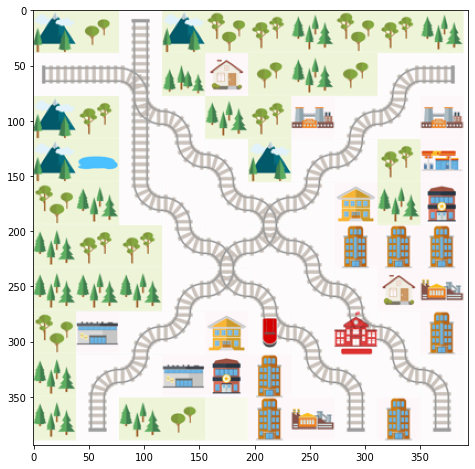

In [298]:
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.observations import GlobalObsForRailEnv

seed = 69 #nice

width = 10 # @param{type: "integer"}
height = 10 # @param{type: "integer"}
agents =  1 # @param{type: "integer"}
WINDOW_LENGTH =   21# @param{type: "integer"}


random_rail_generator = complex_rail_generator(
    nr_start_goal=10, # @param{type:"integer"} number of start and end goals 
                      # connections, the higher the easier it should be for 
                      # the trains
    nr_extra=10, # @param{type:"integer"} extra connections 
                 # (useful for alternite paths), the higher the easier
    min_dist=10,
    max_dist=99999,
    seed=seed
)

env = OurEnv(
    width=width,
    height=height,
    rail_generator=random_rail_generator,
    obs_builder_object=GlobalObsForRailEnv(),
    number_of_agents=agents
)

# env.reset is needed to build the first step of the env
_ = env.reset() # assigned to _ just to suppress the output

To render the env we use RenderTool. I think `gl="PILSVG"` is the lib used to actually render, using the default one doesn't work.

The function `render_env(env)` shows the env using matplotlib.

In [5]:
from flatland.utils.rendertools import RenderTool
import matplotlib.pyplot as plt

def render_env(env, figsize=(8, 8)):
  """Show the environment using matplotlib"""
  env_renderer = RenderTool(env, gl="PILSVG")
  # img is a numpy array
  img = env_renderer.render_env(show=True, return_image=True)

  plt.figure(figsize=figsize)
  plt.imshow(img)
  plt.show()

/usr/local/lib/python3.7/dist-packages/flatland/utils/rendertools.py:399: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


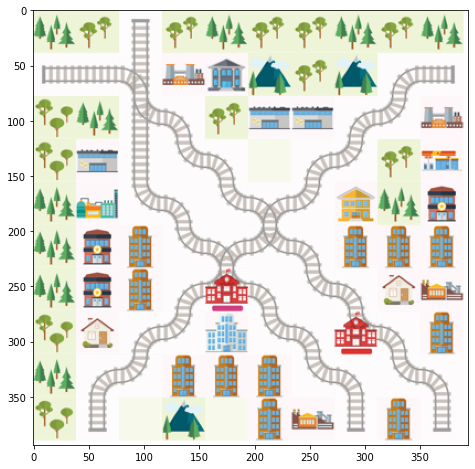

In [218]:
render_env(env)

Let's perform a basic action for each train.

The actions are (as defined [here](http://flatland-rl-docs.s3-website.eu-central-1.amazonaws.com/04_specifications.html#action-space)):
* 0 Do Nothing: If the agent is moving it continues moving, if it is stopped it stays stopped
* 1 Deviate Left: If the agent is at a switch with a transition to its left, the agent will chose th eleft path. Otherwise the action has no effect. If the agent is stopped, this action will start agent movement again if allowed by the transitions.
* 2 Go Forward: This action will start the agent when stopped. This will move the agent forward and chose the go straight direction at switches.
* 3 Deviate Right: Exactly the same as deviate left but for right turns.
* 4 Stop: This action causes the agent to stop.


In [230]:
# perform Go Forward (2) for each agent
handles = env.get_agent_handles()
action_dict = {handle:2 for handle in handles}
obs, all_rewards, done, _ = env.step(action_dict)

{0: 2, 1: 2}


/usr/local/lib/python3.7/dist-packages/flatland/utils/rendertools.py:399: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


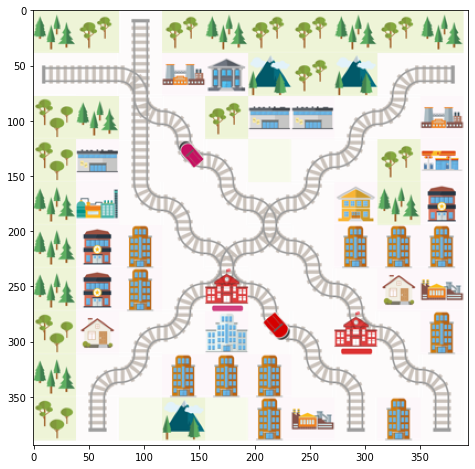

In [231]:
render_env(env)

In [232]:
# perform Go Forward (2) for each agent again
handles = env.get_agent_handles()
action_dict = {handle:2 for handle in handles}
obs, all_rewards, done, _ = env.step(action_dict)

{0: 2, 1: 2}


/usr/local/lib/python3.7/dist-packages/flatland/utils/rendertools.py:399: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


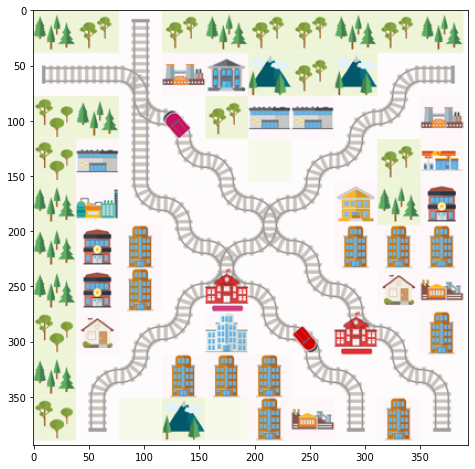

In [233]:
render_env(env)

Building an env is quite easy and straightforward.

# Training

Loading (and owning) some libs

In [234]:
from PIL import Image
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

Using Railprocessor and related from simmy

In [313]:
class RailProcessor(Processor):
    def process_observation(self, observation):
        render_env(env)
        if type(observation) is not tuple:
            return np.array(observation[0][1]).flatten()
        return np.array(observation[0][0][1]).flatten() #reshape((5,10,10))[0]
        #return np.array(observation[0][0][0]).flatten() # For now, we'll just keep the transition maps
    def process_reward(self, reward):
        reward_sum = 0
        for _, train_reward in reward.items():
            reward_sum += train_reward
        return reward_sum
    def process_action(self, action):        
        return {0: RailEnvActions(action)}
    def process_step(self,*args, **kwargs):
        observation, reward, done, info = super().process_step(*args, **kwargs)
        done = done["__all__"]
        return observation, reward, done, {}

In [236]:
nb_actions = env.action_space[0]
nb_actions

5

In [237]:
og_input_shape = np.array(env.step({0: RailEnvActions.DO_NOTHING})[0][0][1]).flatten().shape
og_input_shape

{0: <RailEnvActions.DO_NOTHING: 0>}


(500,)

Build a model, does annoying error which I was not able to fix yet

In [238]:
RailEnvActions(4)

<RailEnvActions.STOP_MOVING: 4>

In [239]:
print(np.array(env.reset()[0][0][1]).flatten().shape)
print(np.array(env.step({0: RailEnvActions.STOP_MOVING})[0][0][1]).flatten().shape)
print(np.array(env.step({0: RailEnvActions.MOVE_FORWARD})[0][0][1]).flatten().shape)

(500,)
{0: <RailEnvActions.STOP_MOVING: 4>}
(500,)
{0: <RailEnvActions.MOVE_FORWARD: 2>}
(500,)


In [240]:
input_shape

(4, 500)

In [286]:
input_shape = (WINDOW_LENGTH,) + og_input_shape
model = Sequential()
timesteps = 1 #1 timestep as tree is only 1 deep
model.add(Input(shape=input_shape, name="INSERIMENTO_DATI"))
#model.add(Embedding(input_dim=input_shape[0], output_dim=64))
model.add(LSTM(75, return_sequences=True, activation="relu", batch_input_shape=( 4, 5, 500)))
model.add(LSTM(50, return_sequences=True, activation="relu"))
model.add(Flatten())
model.add(Dense(20, activation="relu"))
model.add(Dense(nb_actions, activation="linear"))
print(model.summary())

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 21, 75)            172800    
_________________________________________________________________
lstm_73 (LSTM)               (None, 21, 50)            25200     
_________________________________________________________________
flatten_23 (Flatten)         (None, 1050)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 20)                21020     
_________________________________________________________________
dense_68 (Dense)             (None, 5)                 105       
Total params: 219,125
Trainable params: 219,125
Non-trainable params: 0
_________________________________________________________________
None


In [314]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = RailProcessor()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=10, delta_clip=1.)
dqn.compile(Adam(lr=.00025), metrics=['mae'])

In [243]:
callbacks

Training for 1750000 steps ...
{0: <RailEnvActions.MOVE_FORWARD: 2>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


/usr/local/lib/python3.7/dist-packages/flatland/utils/rendertools.py:399: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


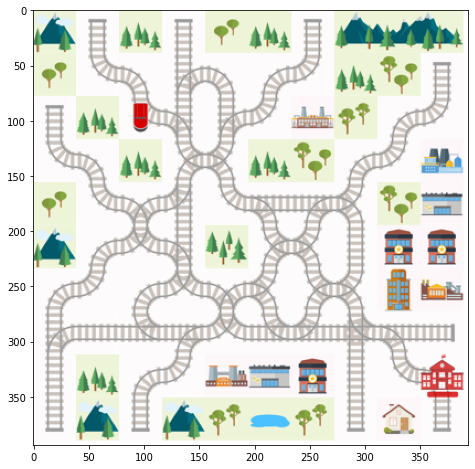

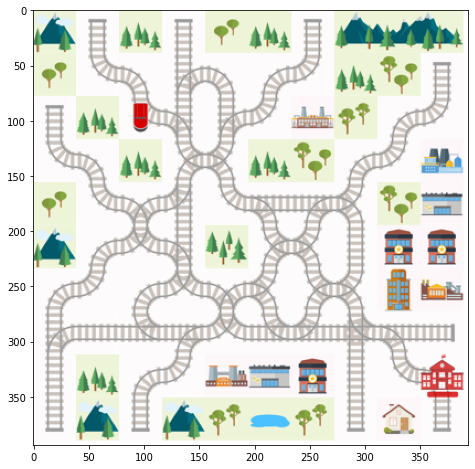

Interval 1 (0 steps performed)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


{0: <RailEnvActions.MOVE_LEFT: 1>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


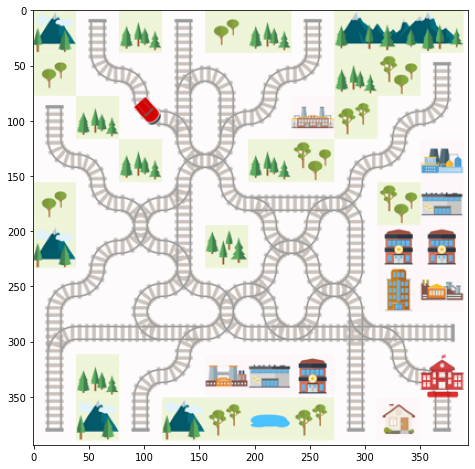

    1/10000 [..............................] - ETA: 35:21:34 - reward: -1.0000{0: <RailEnvActions.STOP_MOVING: 4>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


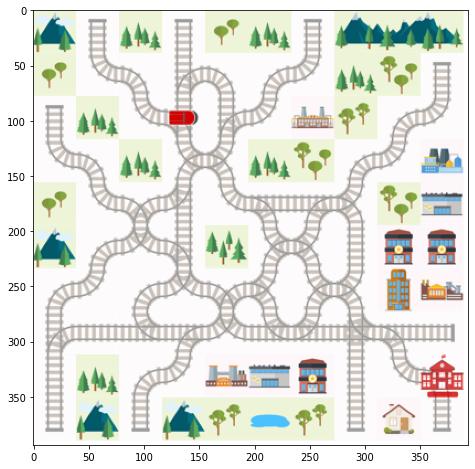

    2/10000 [..............................] - ETA: 7:18:40 - reward: -1.0000 {0: <RailEnvActions.MOVE_FORWARD: 2>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


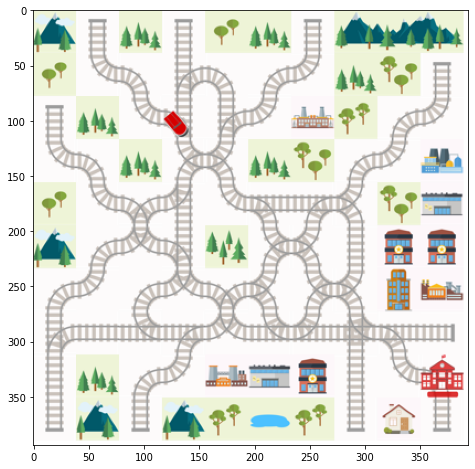

    3/10000 [..............................] - ETA: 7:20:50 - reward: -1.0000{0: <RailEnvActions.MOVE_RIGHT: 3>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


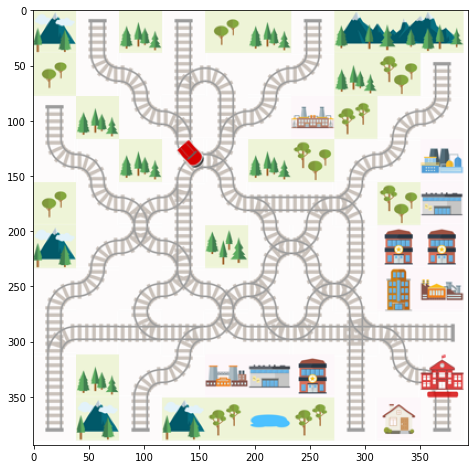

    4/10000 [..............................] - ETA: 7:19:57 - reward: -1.0000{0: <RailEnvActions.MOVE_RIGHT: 3>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


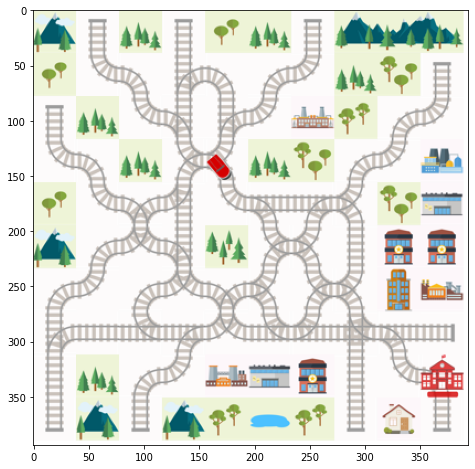

    5/10000 [..............................] - ETA: 7:19:35 - reward: -1.0000{0: <RailEnvActions.MOVE_LEFT: 1>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


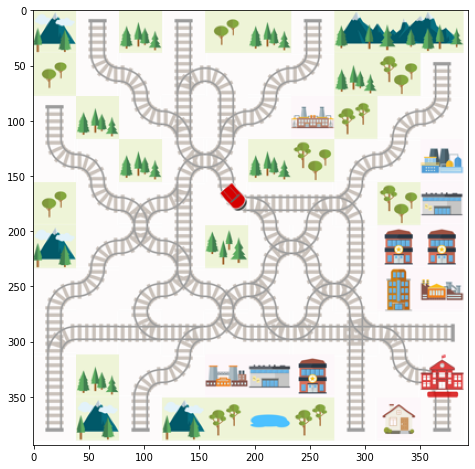

    6/10000 [..............................] - ETA: 7:19:25 - reward: -1.0000{0: <RailEnvActions.MOVE_FORWARD: 2>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


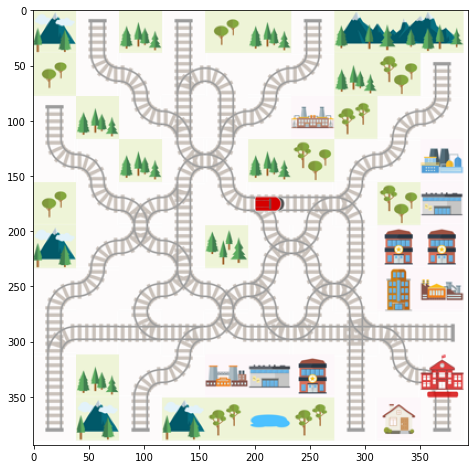

    7/10000 [..............................] - ETA: 7:20:05 - reward: -1.0000{0: <RailEnvActions.DO_NOTHING: 0>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


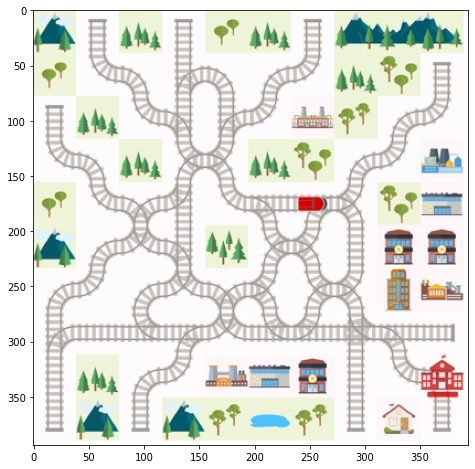

    8/10000 [..............................] - ETA: 7:19:50 - reward: -1.0000{0: <RailEnvActions.MOVE_LEFT: 1>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


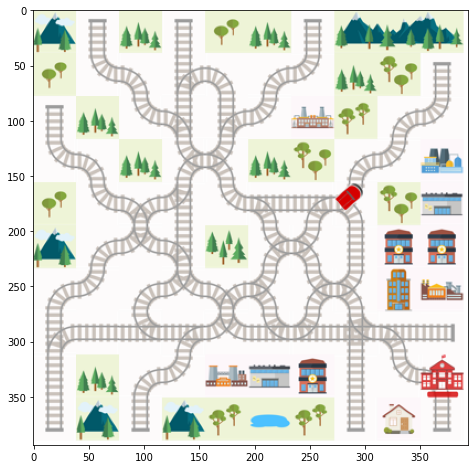

    9/10000 [..............................] - ETA: 7:19:29 - reward: -1.0000{0: <RailEnvActions.STOP_MOVING: 4>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


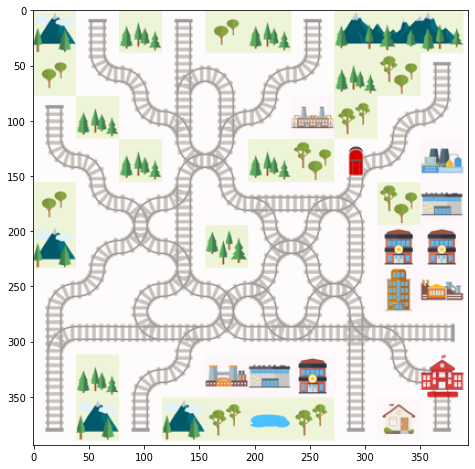

   10/10000 [..............................] - ETA: 7:19:33 - reward: -1.0000{0: <RailEnvActions.MOVE_RIGHT: 3>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


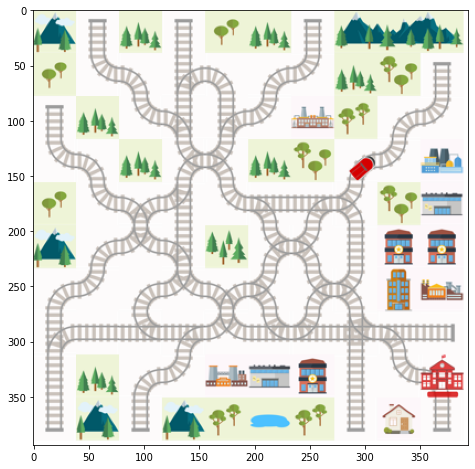

   11/10000 [..............................] - ETA: 7:19:40 - reward: -1.0000{0: <RailEnvActions.MOVE_LEFT: 1>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


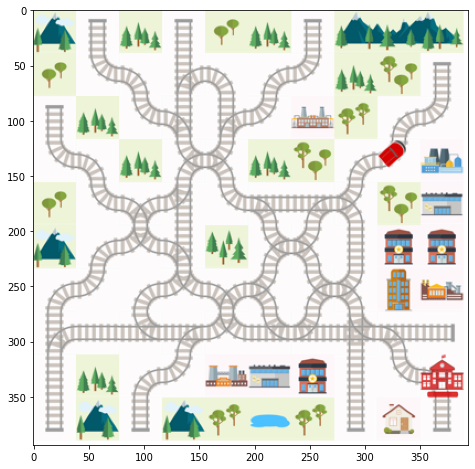

   12/10000 [..............................] - ETA: 7:19:48 - reward: -1.0000{0: <RailEnvActions.MOVE_LEFT: 1>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


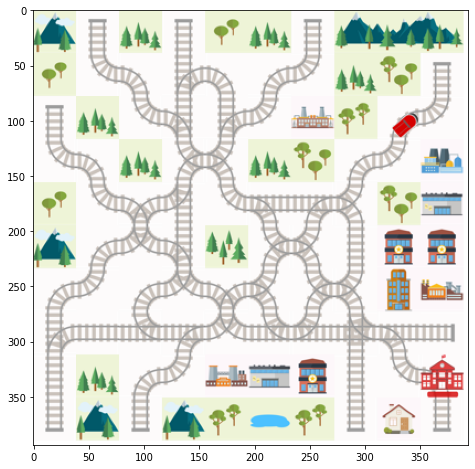

   13/10000 [..............................] - ETA: 7:19:35 - reward: -1.0000{0: <RailEnvActions.MOVE_RIGHT: 3>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


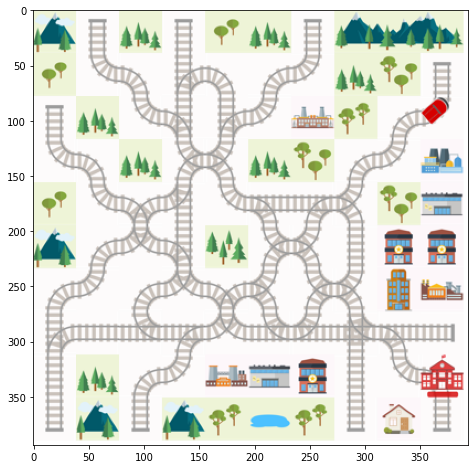

   14/10000 [..............................] - ETA: 7:19:40 - reward: -1.0000{0: <RailEnvActions.MOVE_RIGHT: 3>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


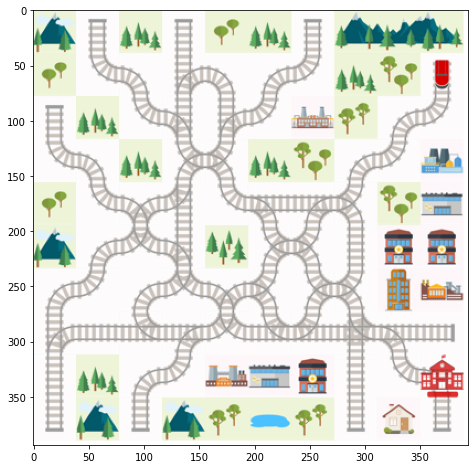

   15/10000 [..............................] - ETA: 7:19:52 - reward: -1.0000{0: <RailEnvActions.STOP_MOVING: 4>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


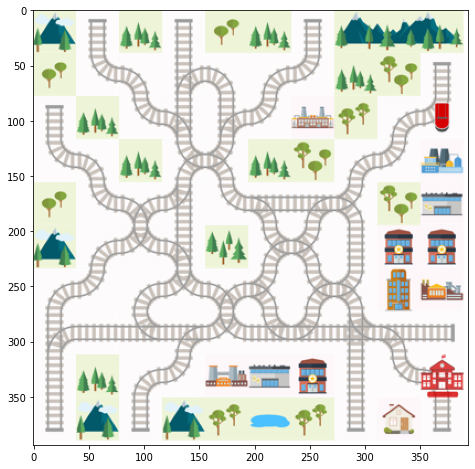

   16/10000 [..............................] - ETA: 7:19:57 - reward: -1.0000{0: <RailEnvActions.DO_NOTHING: 0>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


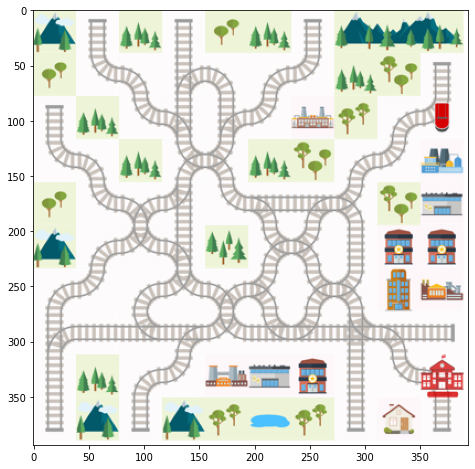

   17/10000 [..............................] - ETA: 7:20:43 - reward: -1.0000{0: <RailEnvActions.STOP_MOVING: 4>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


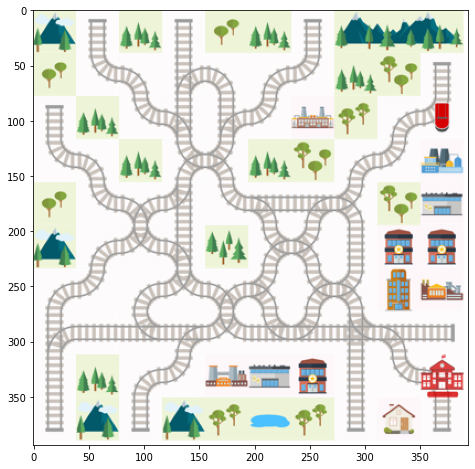

   18/10000 [..............................] - ETA: 7:20:54 - reward: -1.0000{0: <RailEnvActions.MOVE_FORWARD: 2>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


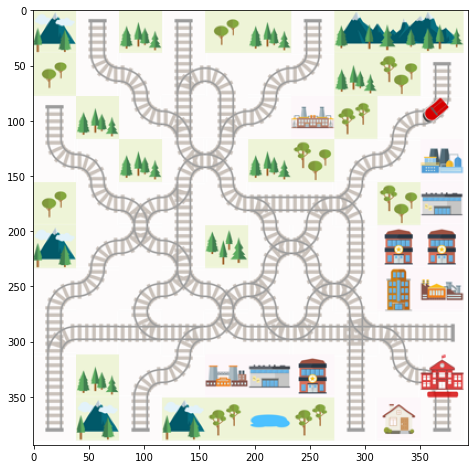

   19/10000 [..............................] - ETA: 7:21:03 - reward: -1.0000{0: <RailEnvActions.MOVE_LEFT: 1>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


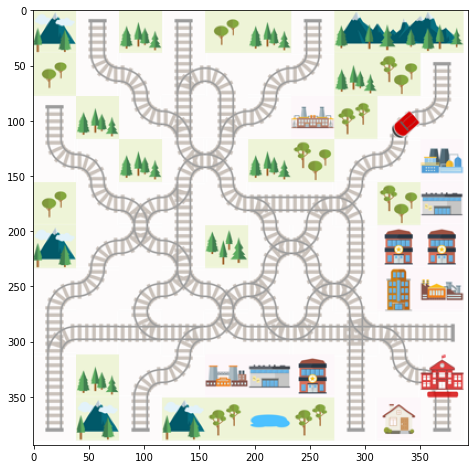

   20/10000 [..............................] - ETA: 7:26:46 - reward: -1.0000{0: <RailEnvActions.MOVE_FORWARD: 2>}
({0: False, '__all__': False}, {'action_required': {0: True}, 'malfunction': {0: 0}, 'speed': {0: 1.0}, 'status': {0: <RailAgentStatus.ACTIVE: 1>}})


In [ ]:
# Okay, now it's time to learn something! We capture the interrupt exception so that training
# can be prematurely aborted. Notice that now you can use the built-in tensorflow.keras callbacks!
weights_filename = 'dqn_flatland_weights.h5f'
checkpoint_weights_filename = 'dqn_flatland_weights_{step}.h5f'
log_filename = 'dqn_flatland_log.json'
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
dqn.fit(env, callbacks=callbacks, nb_steps=1750000, log_interval=10000)

# After training is done, we save the final weights one more time.
dqn.save_weights(weights_filename, overwrite=True)

# Finally, evaluate our algorithm for 10 episodes.
dqn.test(env, nb_episodes=10, visualize=False)

/usr/local/lib/python3.7/dist-packages/flatland/utils/rendertools.py:399: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


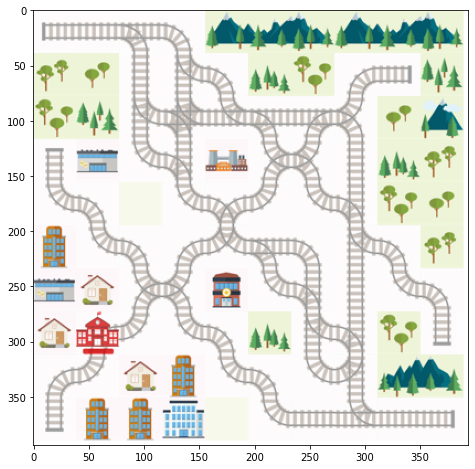

In [266]:
render_env(env)

## Random client
from [here](https://gitlab.aicrowd.com/flatland/flatland/blob/master/examples/training_example.py).

In [245]:
"""
# Initialize the agent, state size is width * height using GlobalObservation
# actions are 5
agent = RandomAgent(width * height, 5)

n_trials = 2 # @param{type:"integer"}
steps_per_episode = 500 # @param{type:"integer"}
for trials in range(1, n_trials + 1):
    obs, info = env.reset()
    
    score = 0
    # Run episode
    for step in range(steps_per_episode):
        # Chose an action for each agent in the environment
        for a in range(env.get_num_agents()):
            action = agent.act(obs[a])
            action_dict.update({a: action})
        
        # Environment step which returns the observations for all agents, 
        # their corresponding reward and whether their are done
        next_obs, all_rewards, done, _ = env.step(action_dict)
        render_env(env)

        if done['__all__']:
            break
    
    print('Episode Nr. {}\t Score = {}'.format(trials, score))


SyntaxError: ignored